# File Receipt Prediction Model - Business Rules Applied
Predict daily AM/PM file counts with proper business constraints:
- Monday-Friday: AM and PM sessions
- Saturday: AM only
- Sunday: No files
- All times in EST

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [6]:
# Load JSON data with EST timezone and business rules
def load_data(json_file_path):
    with open(json_file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    
    df = pd.DataFrame(data)
    

    # Parse EST timestamps
    df['datetime'] = pd.to_datetime(df['fil_creatn_dt'] + ' ' + df['fil_creatn_time'], 
                                   format='%Y-%m-%d %H.%M.%S')
    
    df['date'] = df['datetime'].dt.date
    df['is_am'] = df['datetime'].dt.hour < 12
    df['day_of_week'] = df['datetime'].dt.dayofweek  # 0=Mon, 6=Sun
    df['day_name'] = df['datetime'].dt.day_name()

    cutoff_date = datetime.now() - timedelta(days=5*365)
    df = df[df['datetime'] >= cutoff_date]
    print(f"Filtered to last 5 years: {len(df)} records from {cutoff_date.date()} onwards")
    
    # Verify business rules in existing data
    sunday_files = len(df[df['day_of_week'] == 6])
    sat_pm_files = len(df[(df['day_of_week'] == 5) & (df['is_am'] == False)])
    
    print(f"Total records: {len(df)}")
    print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()} (EST)")
    print(f"Sunday files found: {sunday_files} (should be 0)")
    print(f"Saturday PM files found: {sat_pm_files} (should be 0)")
    
    return df

df = load_data('file_audit.json')
# Filter for last 5 years only

df.head()

Filtered to last 5 years: 6866 records from 2020-10-05 onwards
Total records: 6866
Date range: 2020-10-05 04:33:58 to 2025-09-27 03:38:34 (EST)
Sunday files found: 1 (should be 0)
Saturday PM files found: 1 (should be 0)


,fil_audt_key_id,fil_creatn_dt,fil_creatn_time,in_plan_hdr_cnt,in_fil_pkg_hdr_cnt,in_tot_dtl_cnt,in_pkg_trlr_cnt,in_plan_trlr_cnt,in_tot_rec_cnt,out_plan_hdr_cnt,...,fil_id,proc_strt_dt,proc_strt_time,proc_end_dt,proc_end_time,datetime,date,is_am,day_of_week,day_name
16530,5465888,2020-10-05,04.33.58,1,7,100519,7,1,100537,1,...,2020279043301,2020-10-05,04.46.44,2020-10-05,19.33.17,2020-10-05 04:33:58,2020-10-05,True,0,Monday
16531,5465897,2020-10-05,04.33.58,1,376,2999245,376,1,3000001,1,...,2020279043302,2020-10-05,04.47.01,2020-10-05,19.33.17,2020-10-05 04:33:58,2020-10-05,True,0,Monday
16532,5466275,2020-10-05,04.34.10,37,935,2652944,935,37,2654890,37,...,2020279043403,2020-10-05,04.47.49,2020-10-05,19.33.17,2020-10-05 04:34:10,2020-10-05,True,0,Monday
16533,5467248,2020-10-05,04.34.20,1,326,2999345,326,1,3000001,1,...,2020279043404,2020-10-05,04.48.23,2020-10-05,19.33.17,2020-10-05 04:34:20,2020-10-05,True,0,Monday
16534,5467576,2020-10-05,04.34.31,11,67,536960,67,11,537118,11,...,2020279043405,2020-10-05,04.48.43,2020-10-05,19.33.17,2020-10-05 04:34:31,2020-10-05,True,0,Monday


In [7]:
# Create daily session summary
daily_stats = df.groupby(['date', 'is_am']).agg({
    'fil_id': 'count',
    'in_tot_rec_cnt': 'sum'
}).reset_index()

daily_stats.columns = ['date', 'is_am', 'file_count', 'total_records']
daily_stats['datetime'] = pd.to_datetime(daily_stats['date'])
daily_stats['day_of_week'] = daily_stats['datetime'].dt.dayofweek
daily_stats['day_name'] = daily_stats['datetime'].dt.day_name()
daily_stats['session'] = daily_stats['is_am'].map({True: 'AM', False: 'PM'})

print(f"Daily sessions: {len(daily_stats)}")
print(f"Sunday sessions: {len(daily_stats[daily_stats['day_of_week'] == 6])}")
print(f"Saturday PM sessions: {len(daily_stats[(daily_stats['day_of_week'] == 5) & (daily_stats['is_am'] == False)])}")
print(f"Saturday AM sessions: {len(daily_stats[(daily_stats['day_of_week'] == 5) & (daily_stats['is_am'] == True)])}")

daily_stats.head(10)

Daily sessions: 2856
Sunday sessions: 1
Saturday PM sessions: 1
Saturday AM sessions: 257


,date,is_am,file_count,total_records,datetime,day_of_week,day_name,session
0,2020-10-05,False,1,2946065,2020-10-05,0,Monday,PM
1,2020-10-05,True,8,16323993,2020-10-05,0,Monday,AM
2,2020-10-06,False,6,14715375,2020-10-06,1,Tuesday,PM
3,2020-10-06,True,1,442996,2020-10-06,1,Tuesday,AM
4,2020-10-07,False,1,593879,2020-10-07,2,Wednesday,PM
5,2020-10-07,True,5,10769048,2020-10-07,2,Wednesday,AM
6,2020-10-08,False,1,129955,2020-10-08,3,Thursday,PM
7,2020-10-08,True,1,51433,2020-10-08,3,Thursday,AM
8,2020-10-09,False,1,182710,2020-10-09,4,Friday,PM
9,2020-10-09,True,1,189930,2020-10-09,4,Friday,AM


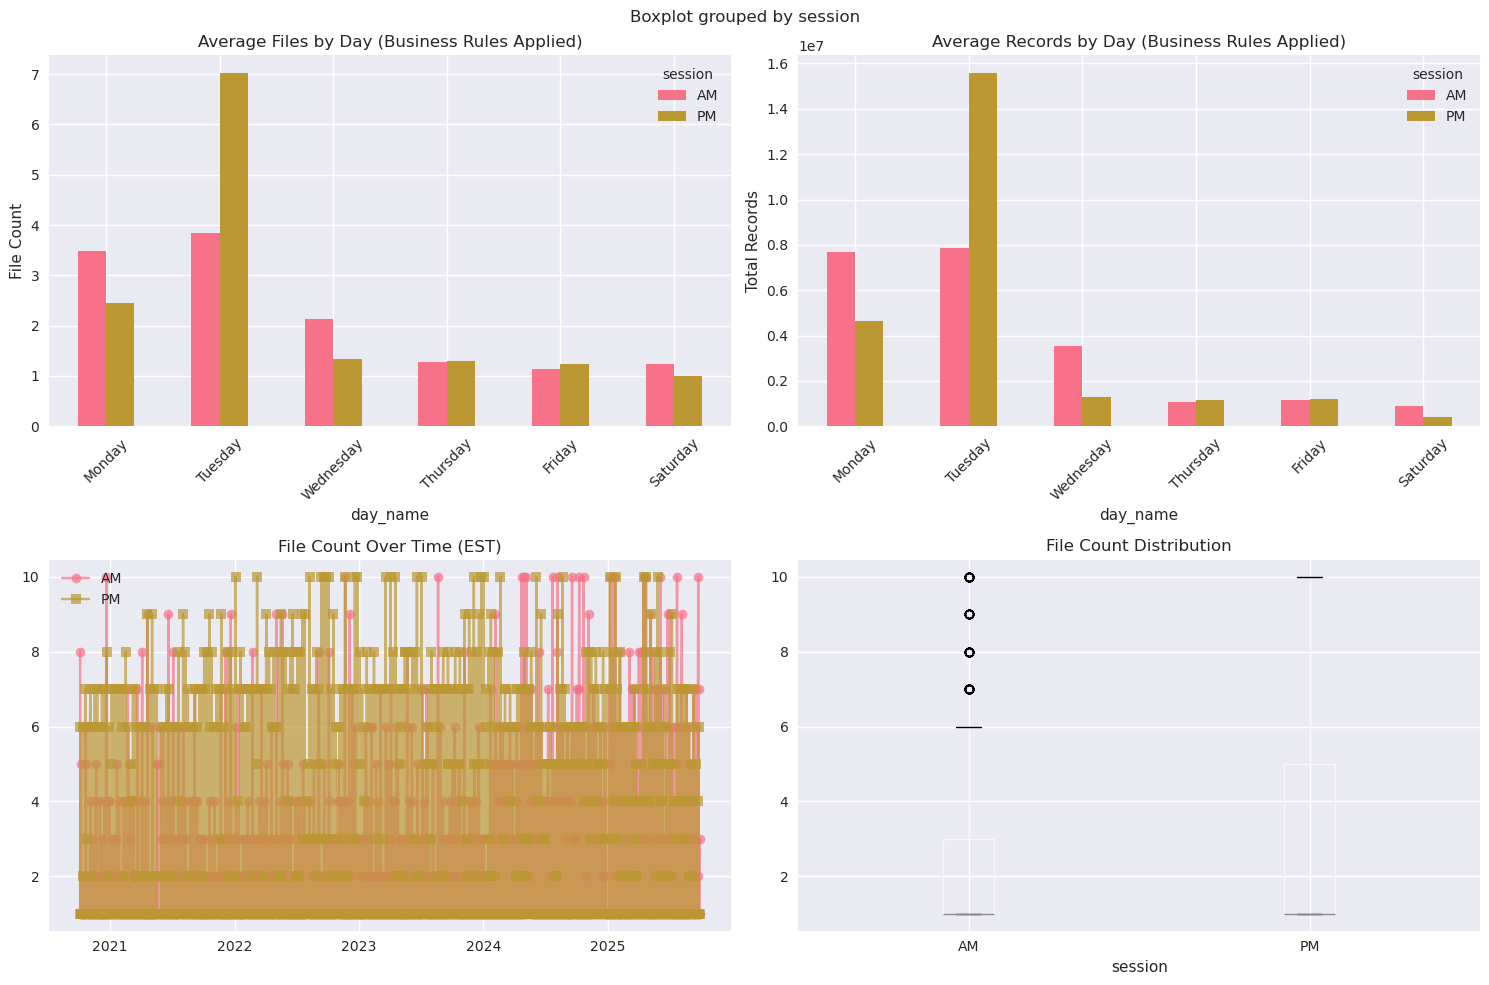


Business Rules:
• Monday-Friday: AM and PM sessions
• Saturday: AM session only
• Sunday: No sessions
• All times in EST


In [8]:
# Visualize patterns with business rules
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Files by day of week (business days only)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
business_stats = daily_stats[daily_stats['day_of_week'] < 6]  # Exclude Sunday

# Create pivot with proper business rules
file_pivot = business_stats.groupby(['day_name', 'session'])['file_count'].mean().unstack(fill_value=0)
file_pivot = file_pivot.reindex(day_order, fill_value=0)
file_pivot.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Average Files by Day (Business Rules Applied)')
axes[0,0].set_ylabel('File Count')
axes[0,0].set_xticklabels(day_order, rotation=45)

# Records by day of week
record_pivot = business_stats.groupby(['day_name', 'session'])['total_records'].mean().unstack(fill_value=0)
record_pivot = record_pivot.reindex(day_order, fill_value=0)
record_pivot.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Average Records by Day (Business Rules Applied)')
axes[0,1].set_ylabel('Total Records')
axes[0,1].set_xticklabels(day_order, rotation=45)

# Time series
am_data = daily_stats[daily_stats['is_am'] == True].set_index('datetime')['file_count']
pm_data = daily_stats[daily_stats['is_am'] == False].set_index('datetime')['file_count']
axes[1,0].plot(am_data.index, am_data.values, 'o-', label='AM', alpha=0.7)
axes[1,0].plot(pm_data.index, pm_data.values, 's-', label='PM', alpha=0.7)
axes[1,0].set_title('File Count Over Time (EST)')
axes[1,0].legend()

# Distribution
daily_stats.boxplot(column='file_count', by='session', ax=axes[1,1])
axes[1,1].set_title('File Count Distribution')

plt.tight_layout()
plt.show()

print("\nBusiness Rules:")
print("• Monday-Friday: AM and PM sessions")
print("• Saturday: AM session only")
print("• Sunday: No sessions")
print("• All times in EST")

In [9]:
class FilePredictor:
    def __init__(self, model_type='statistical'):
        self.model_type = model_type
        if model_type == 'ml':
            self.am_file_model = PoissonRegressor(alpha=0.1)
            self.am_record_model = LinearRegression()
            self.pm_file_model = PoissonRegressor(alpha=0.1)
            self.pm_record_model = LinearRegression()
            self.scaler = StandardScaler()
        else:
            self.am_stats = {}
            self.pm_stats = {}
    
    def train(self, daily_stats):
        if self.model_type == 'statistical':
            # Business rules: Mon-Fri AM/PM, Sat AM only, Sun none
            for dow in range(6):  # Only Mon-Sat (0-5)
                am_data = daily_stats[(daily_stats['day_of_week'] == dow) & (daily_stats['is_am'] == True)]
                
                if len(am_data) > 0:
                    self.am_stats[dow] = {
                        'avg_files': am_data['file_count'].mean(),
                        'avg_records': am_data['total_records'].mean()
                    }
                
                # PM data only for Mon-Fri (0-4)
                if dow < 5:
                    pm_data = daily_stats[(daily_stats['day_of_week'] == dow) & (daily_stats['is_am'] == False)]
                    if len(pm_data) > 0:
                        self.pm_stats[dow] = {
                            'avg_files': pm_data['file_count'].mean(),
                            'avg_records': pm_data['total_records'].mean()
                        }
        
        else:  # ML approach with business rules
            # Only train on valid business day data
            valid_data = daily_stats[
                ~((daily_stats['day_of_week'] == 6)) &  # No Sunday
                ~((daily_stats['day_of_week'] == 5) & (daily_stats['is_am'] == False))  # No Sat PM
            ]
            
            feature_cols = ['day_of_week', 'datetime']
            valid_data['month'] = valid_data['datetime'].dt.month
            valid_data['day_of_month'] = valid_data['datetime'].dt.day
            
            features = ['day_of_week', 'month', 'day_of_month']
            
            am_data = valid_data[valid_data['is_am'] == True]
            pm_data = valid_data[valid_data['is_am'] == False]
            
            if len(am_data) > 0:
                X_am = self.scaler.fit_transform(am_data[features])
                self.am_file_model.fit(X_am, am_data['file_count'])
                self.am_record_model.fit(X_am, am_data['total_records'])
            
            if len(pm_data) > 0:
                X_pm = self.scaler.transform(pm_data[features])
                self.pm_file_model.fit(X_pm, pm_data['file_count'])
                self.pm_record_model.fit(X_pm, pm_data['total_records'])
    
    def predict(self, target_date, is_am=True):
        target_dt = pd.to_datetime(target_date)
        dow = target_dt.dayofweek
        
        # Business rules enforcement
        if dow == 6:  # Sunday - no files
            return 0, 0
        elif dow == 5 and not is_am:  # Saturday PM - no files
            return 0, 0
        
        if self.model_type == 'statistical':
            stats = self.am_stats if is_am else self.pm_stats
            if dow in stats:
                return (min(10, max(0, int(round(stats[dow]['avg_files'])))), 
                       max(0, int(round(stats[dow]['avg_records']))))
            return 0, 0
        
        else:  # ML approach
            features = np.array([[dow, target_dt.month, target_dt.day]])
            features_scaled = self.scaler.transform(features)
            
            if is_am:
                file_pred = self.am_file_model.predict(features_scaled)[0]
                record_pred = self.am_record_model.predict(features_scaled)[0]
            else:
                file_pred = self.pm_file_model.predict(features_scaled)[0]
                record_pred = self.pm_record_model.predict(features_scaled)[0]
            
            return (min(10, max(0, int(round(file_pred)))), 
                   max(0, int(round(record_pred))))

In [10]:
# Train models
stat_model = FilePredictor('statistical')
ml_model = FilePredictor('ml')

stat_model.train(daily_stats)
ml_model.train(daily_stats)

print("Models trained with business rules applied!")
print(f"Statistical model - AM stats: {len(stat_model.am_stats)} days")
print(f"Statistical model - PM stats: {len(stat_model.pm_stats)} days")

Models trained with business rules applied!
Statistical model - AM stats: 6 days
Statistical model - PM stats: 5 days


Statistical Model - Sample Actual vs Predicted:
         date   day_name session  actual_files  predicted_files  file_error
0  2020-10-05     Monday      PM             1                2           1
1  2020-10-05     Monday      AM             8                3           5
2  2020-10-06    Tuesday      PM             6                7           1
3  2020-10-06    Tuesday      AM             1                4           3
4  2020-10-07  Wednesday      PM             1                1           0
5  2020-10-07  Wednesday      AM             5                2           3
6  2020-10-08   Thursday      PM             1                1           0
7  2020-10-08   Thursday      AM             1                1           0
8  2020-10-09     Friday      PM             1                1           0
9  2020-10-09     Friday      AM             1                1           0

Statistical Model MAE (files): 0.84
ML Model MAE (files): 1.47


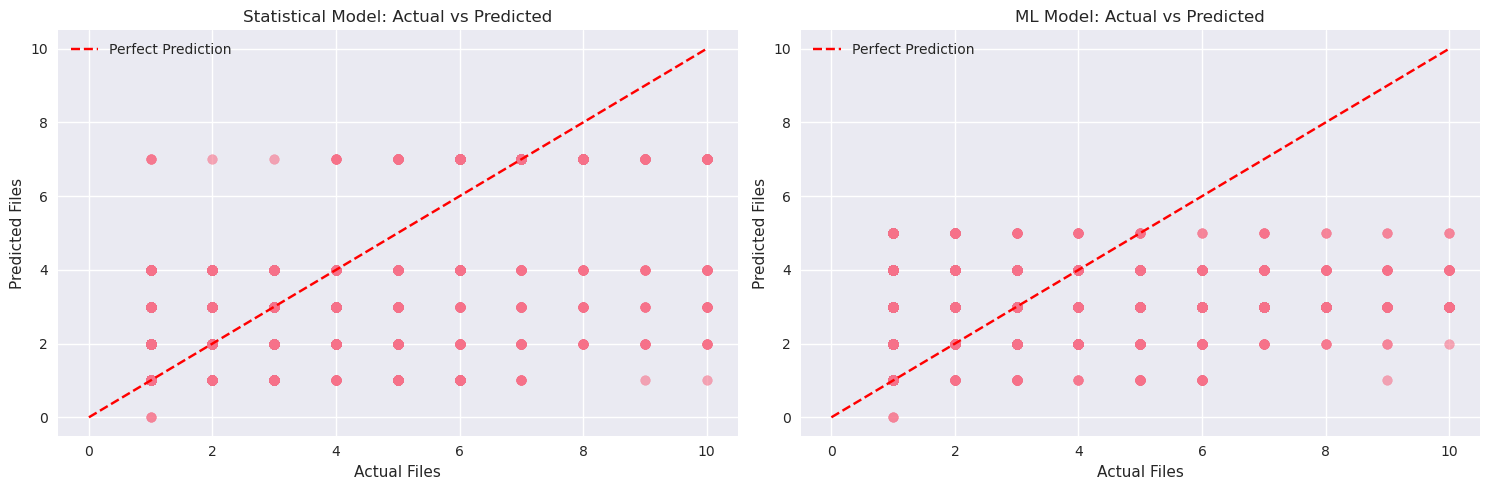

In [13]:
# Actual vs Predicted Comparison
def compare_predictions(daily_stats, model, model_name):
    results = []
    for _, row in daily_stats.iterrows():
        date_str = row['date'].strftime('%Y-%m-%d')
        pred = model.predict(date_str, row['is_am'])
        
        results.append({
            'date': date_str,
            'day_name': row['day_name'],
            'session': 'AM' if row['is_am'] else 'PM',
            'actual_files': row['file_count'],
            'predicted_files': pred[0],
            'actual_records': row['total_records'],
            'predicted_records': pred[1],
            'file_error': abs(row['file_count'] - pred[0])
        })
    
    return pd.DataFrame(results)

# Compare both models
stat_comparison = compare_predictions(daily_stats, stat_model, 'Statistical')
ml_comparison = compare_predictions(daily_stats, ml_model, 'ML')

# Show sample comparisons
print("Statistical Model - Sample Actual vs Predicted:")
print(stat_comparison[['date', 'day_name', 'session', 'actual_files', 'predicted_files', 'file_error']].head(10))

print(f"\nStatistical Model MAE (files): {stat_comparison['file_error'].mean():.2f}")
print(f"ML Model MAE (files): {ml_comparison['file_error'].mean():.2f}")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Statistical model
axes[0].scatter(stat_comparison['actual_files'], stat_comparison['predicted_files'], alpha=0.6)
axes[0].plot([0, 10], [0, 10], 'r--', label='Perfect Prediction')
axes[0].set_xlabel('Actual Files')
axes[0].set_ylabel('Predicted Files')
axes[0].set_title('Statistical Model: Actual vs Predicted')
axes[0].legend()

# ML model
axes[1].scatter(ml_comparison['actual_files'], ml_comparison['predicted_files'], alpha=0.6)
axes[1].plot([0, 10], [0, 10], 'r--', label='Perfect Prediction')
axes[1].set_xlabel('Actual Files')
axes[1].set_ylabel('Predicted Files')
axes[1].set_title('ML Model: Actual vs Predicted')
axes[1].legend()

plt.tight_layout()
plt.show()


In [14]:
# Display business-compliant averages
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

print("Historical Averages by Day of Week (EST, Business Rules Applied):")
print("=" * 70)

for i, day in enumerate(days):
    if i == 6:  # Sunday
        print(f"{day:10} AM: No files (business rule)")
        print(f"{' ':10} PM: No files (business rule)")
    elif i == 5:  # Saturday
        am_stats = stat_model.am_stats.get(i, {'avg_files': 0, 'avg_records': 0})
        print(f"{day:10} AM: {am_stats['avg_files']:.1f} files, {am_stats['avg_records']:,.0f} records")
        print(f"{' ':10} PM: No files (business rule)")
    else:  # Monday-Friday
        am_stats = stat_model.am_stats.get(i, {'avg_files': 0, 'avg_records': 0})
        pm_stats = stat_model.pm_stats.get(i, {'avg_files': 0, 'avg_records': 0})
        print(f"{day:10} AM: {am_stats['avg_files']:.1f} files, {am_stats['avg_records']:,.0f} records")
        print(f"{' ':10} PM: {pm_stats['avg_files']:.1f} files, {pm_stats['avg_records']:,.0f} records")
    print()

Historical Averages by Day of Week (EST, Business Rules Applied):
Monday     AM: 3.5 files, 7,685,649 records
           PM: 2.5 files, 4,627,946 records

Tuesday    AM: 3.8 files, 7,843,392 records
           PM: 7.0 files, 15,579,387 records

Wednesday  AM: 2.1 files, 3,524,107 records
           PM: 1.3 files, 1,281,684 records

Thursday   AM: 1.3 files, 1,048,425 records
           PM: 1.3 files, 1,168,446 records

Friday     AM: 1.1 files, 1,136,171 records
           PM: 1.2 files, 1,197,034 records

Saturday   AM: 1.2 files, 902,142 records
           PM: No files (business rule)

Sunday     AM: No files (business rule)
           PM: No files (business rule)



In [17]:
# Test predictions for next week with business rules
test_dates = pd.date_range('2025-09-22', periods=7, freq='D')

print("Predictions for Next Week (Business Rules Applied):")
print("=" * 80)

for date in test_dates:
    date_str = date.strftime('%Y-%m-%d')
    day_name = date.strftime('%A')
    
    # Statistical model predictions
    stat_am = stat_model.predict(date_str, True)
    stat_pm = stat_model.predict(date_str, False)
    
    # ML model predictions
    ml_am = ml_model.predict(date_str, True)
    ml_pm = ml_model.predict(date_str, False)
    
    print(f"{date_str} ({day_name})")
    print(f"  Statistical: AM {stat_am[0]} files/{stat_am[1]:,} records, PM {stat_pm[0]} files/{stat_pm[1]:,} records")
    print(f"  ML Model:    AM {ml_am[0]} files/{ml_am[1]:,} records, PM {ml_pm[0]} files/{ml_pm[1]:,} records")
    
    # Show business rule application
    if day_name == 'Sunday':
        print(f"  → Sunday: No files (business rule)")
    elif day_name == 'Saturday':
        print(f"  → Saturday: AM only (business rule)")
    
    print()

Predictions for Next Week (Business Rules Applied):
2025-09-22 (Monday)
  Statistical: AM 3 files/7,685,649 records, PM 2 files/4,627,946 records
  ML Model:    AM 4 files/7,531,370 records, PM 4 files/8,780,824 records

2025-09-23 (Tuesday)
  Statistical: AM 4 files/7,843,392 records, PM 7 files/15,579,387 records
  ML Model:    AM 3 files/5,891,496 records, PM 3 files/6,614,930 records

2025-09-24 (Wednesday)
  Statistical: AM 2 files/3,524,107 records, PM 1 files/1,281,684 records
  ML Model:    AM 2 files/4,251,622 records, PM 2 files/4,449,036 records

2025-09-25 (Thursday)
  Statistical: AM 1 files/1,048,425 records, PM 1 files/1,168,446 records
  ML Model:    AM 2 files/2,611,747 records, PM 2 files/2,283,141 records

2025-09-26 (Friday)
  Statistical: AM 1 files/1,136,171 records, PM 1 files/1,197,034 records
  ML Model:    AM 1 files/971,873 records, PM 1 files/117,247 records

2025-09-27 (Saturday)
  Statistical: AM 1 files/902,142 records, PM 0 files/0 records
  ML Model:   

In [20]:
# Test predictions with actuals comparison
test_dates = pd.date_range('2025-09-22', periods=7, freq='D')  # Use dates from your data range

print("Predictions vs Actuals (Business Rules Applied):") 
print("=" * 90)

for date in test_dates:
    date_str = date.strftime('%Y-%m-%d')
    day_name = date.strftime('%A')
    
    # Get actual data if exists
    actual_am = daily_stats[(daily_stats['date'] == date.date()) & (daily_stats['is_am'] == True)]
    actual_pm = daily_stats[(daily_stats['date'] == date.date()) & (daily_stats['is_am'] == False)]
    
    actual_am_files = actual_am['file_count'].iloc[0] if len(actual_am) > 0 else 0
    actual_am_records = actual_am['total_records'].iloc[0] if len(actual_am) > 0 else 0
    actual_pm_files = actual_pm['file_count'].iloc[0] if len(actual_pm) > 0 else 0
    actual_pm_records = actual_pm['total_records'].iloc[0] if len(actual_pm) > 0 else 0
    
    # Predictions
    stat_am = stat_model.predict(date_str, True)
    stat_pm = stat_model.predict(date_str, False)
    
    print(f"{date_str} ({day_name})")
    print(f"  Actual:      AM {actual_am_files} files/{actual_am_records:,} records, PM {actual_pm_files} files/{actual_pm_records:,} records")
    print(f"  Statistical: AM {stat_am[0]} files/{stat_am[1]:,} records, PM {stat_pm[0]} files/{stat_pm[1]:,} records")
    
    # Show errors
    am_error = abs(actual_am_files - stat_am[0]) if actual_am_files > 0 or stat_am[0] > 0 else 0
    pm_error = abs(actual_pm_files - stat_pm[0]) if actual_pm_files > 0 or stat_pm[0] > 0 else 0
    print(f"  Difference:       AM {am_error} files, PM {pm_error} files")
    print()


Predictions vs Actuals (Business Rules Applied):
2025-09-22 (Monday)
  Actual:      AM 10 files/24,816,820 records, PM 4 files/10,195,763 records
  Statistical: AM 3 files/7,685,649 records, PM 2 files/4,627,946 records
  Difference:       AM 7 files, PM 2 files

2025-09-23 (Tuesday)
  Actual:      AM 7 files/13,386,216 records, PM 6 files/13,954,760 records
  Statistical: AM 4 files/7,843,392 records, PM 7 files/15,579,387 records
  Difference:       AM 3 files, PM 1 files

2025-09-24 (Wednesday)
  Actual:      AM 1 files/79,454 records, PM 1 files/79,767 records
  Statistical: AM 2 files/3,524,107 records, PM 1 files/1,281,684 records
  Difference:       AM 1 files, PM 0 files

2025-09-25 (Thursday)
  Actual:      AM 1 files/570 records, PM 1 files/200,565 records
  Statistical: AM 1 files/1,048,425 records, PM 1 files/1,168,446 records
  Difference:       AM 0 files, PM 0 files

2025-09-26 (Friday)
  Actual:      AM 1 files/432,705 records, PM 1 files/927,257 records
  Statistical: 

In [12]:
# Interactive prediction function with business rules
def predict_for_date(date_str, model_type='statistical'):
    model = stat_model if model_type == 'statistical' else ml_model
    
    target_dt = pd.to_datetime(date_str)
    day_name = target_dt.strftime('%A')
    
    am_pred = model.predict(date_str, True)
    pm_pred = model.predict(date_str, False)
    
    print(f"Predictions for {date_str} ({day_name}) using {model_type} model:")
    
    if day_name == 'Sunday':
        print("No files expected (Sunday - business rule)")
    elif day_name == 'Saturday':
        print(f"AM Session: {am_pred[0]} files, {am_pred[1]:,} records")
        print("PM Session: No files (Saturday PM - business rule)")
        print(f"Daily Total: {am_pred[0]} files, {am_pred[1]:,} records")
    else:
        print(f"AM Session: {am_pred[0]} files, {am_pred[1]:,} records")
        print(f"PM Session: {pm_pred[0]} files, {pm_pred[1]:,} records")
        print(f"Daily Total: {am_pred[0] + pm_pred[0]} files, {am_pred[1] + pm_pred[1]:,} records")
    
    return am_pred, pm_pred

# Test different days
predict_for_date('2024-12-20', 'statistical')  # Friday
print()
predict_for_date('2024-12-21', 'statistical')  # Saturday
print()
predict_for_date('2024-12-22', 'statistical')  # Sunday

Predictions for 2024-12-20 (Friday) using statistical model:
AM Session: 1 files, 1,136,171 records
PM Session: 1 files, 1,197,034 records
Daily Total: 2 files, 2,333,205 records

Predictions for 2024-12-21 (Saturday) using statistical model:
AM Session: 1 files, 902,142 records
PM Session: No files (Saturday PM - business rule)
Daily Total: 1 files, 902,142 records

Predictions for 2024-12-22 (Sunday) using statistical model:
No files expected (Sunday - business rule)


((0, 0), (0, 0))

In [ ]:
# Save models
joblib.dump(stat_model, 'statistical_model_business_rules.pkl')
joblib.dump(ml_model, 'ml_model_business_rules.pkl')

print("Models saved with business rules applied!")
print("- statistical_model_business_rules.pkl")
print("- ml_model_business_rules.pkl")